<!-- **VISUALISATIONS**
-------

In this notebook, we will visualise the shape of our data -->

**SUMMARY**

In the 2021 census, 30.6% of all occupied private dwellings in Australia were rented. [1]

This project aims to:
- Identify predicted high growth suburbs in Victoria
- Allow investors to maximise their rental yield
- Find areas real estate companies can focus on for increased business

We have looked at 8 features in total:
- Demographic features
  - Population
  - Income
- Proximity to features (both straight line and driving in km)
  - CBD (Central Business District)
  - nearest train station
  - shopping centers or malls
  - schools (primary, secondary and type of school)
  - hospitals or healthcare facilities
  - parks or recreational areas

Below are maps of our features

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

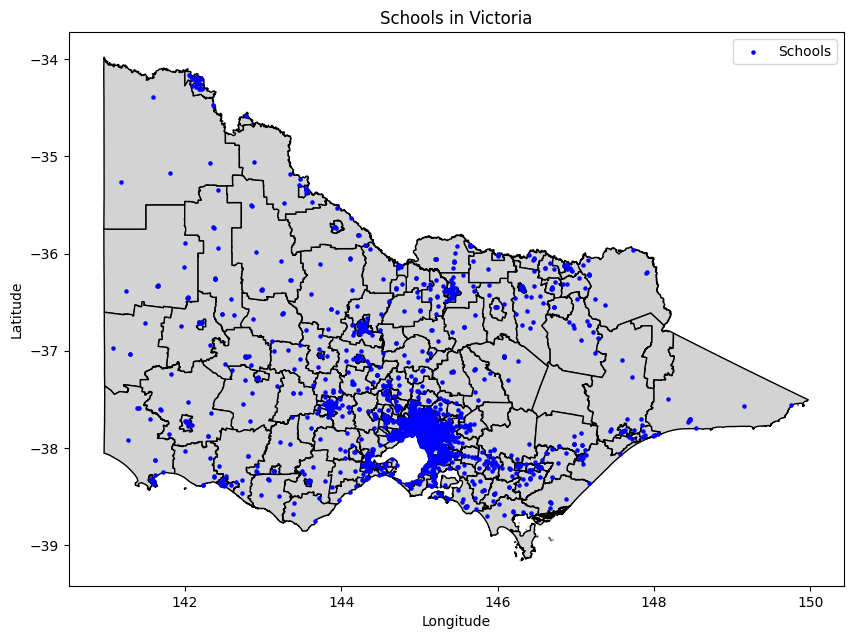

In [9]:
# Step 1: Load the Victoria boundary spatial data (SA2 shapefile)
sa2_path = '../data/sa2_shapefile/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(sa2_path)

# Step 2: Filter to include only Victoria (State code 2)
victoria_gdf = gdf[gdf['STE_CODE21'] == '2']

# Step 3: Load the school data with the correct encoding
school_data_path = '../data/landing/dv346-schoollocations2023.csv'
school_df = pd.read_csv(school_data_path, encoding='ISO-8859-1')  # Use appropriate encoding

# Step 4: Convert the school data into a GeoDataFrame using the Y (latitude) and X (longitude) columns
school_df['geometry'] = school_df.apply(lambda row: Point(row['X'], row['Y']), axis=1)
school_gdf = gpd.GeoDataFrame(school_df, geometry='geometry', crs='EPSG:4326')  # Assuming WGS 84 CRS

# Step 5: Reproject Victoria's shapefile to match the CRS of the school data (if necessary)
victoria_gdf = victoria_gdf.to_crs(epsg=4326)

# Step 6: Plot both the Victoria boundary and school locations
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Victoria boundaries
victoria_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot schools on top
school_gdf.plot(ax=ax, color='blue', markersize=5, label='Schools')

plt.title('Schools in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_665/1946304495.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_665/1946304495.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_665/1946304495.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filt

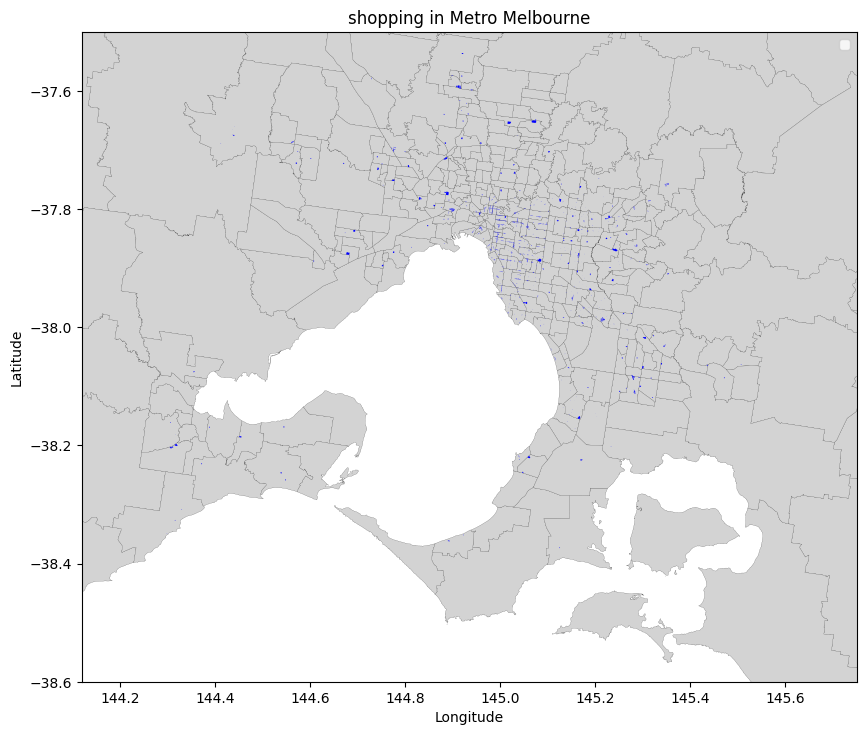

/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_665/1946304495.py:103: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_665/1946304495.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


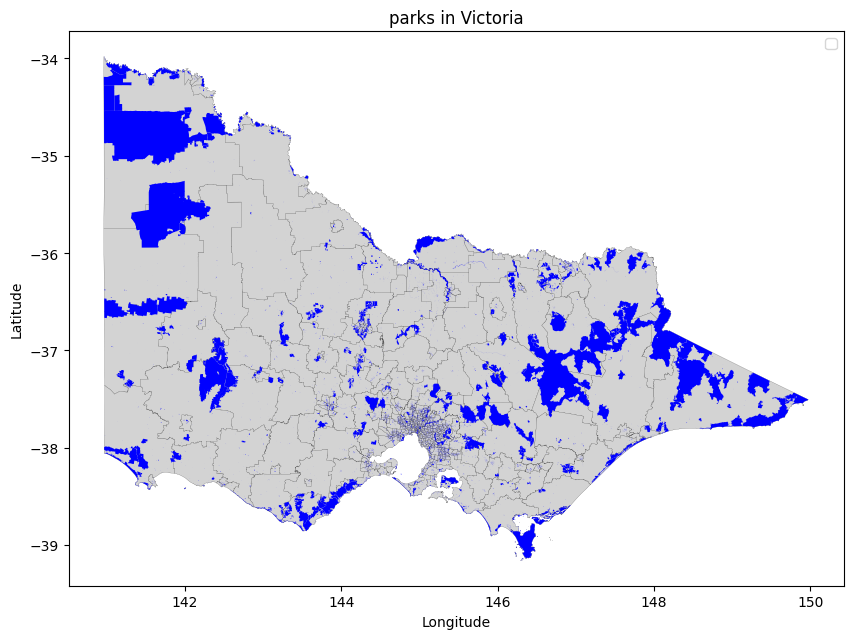

/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_665/1946304495.py:103: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_665/1946304495.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


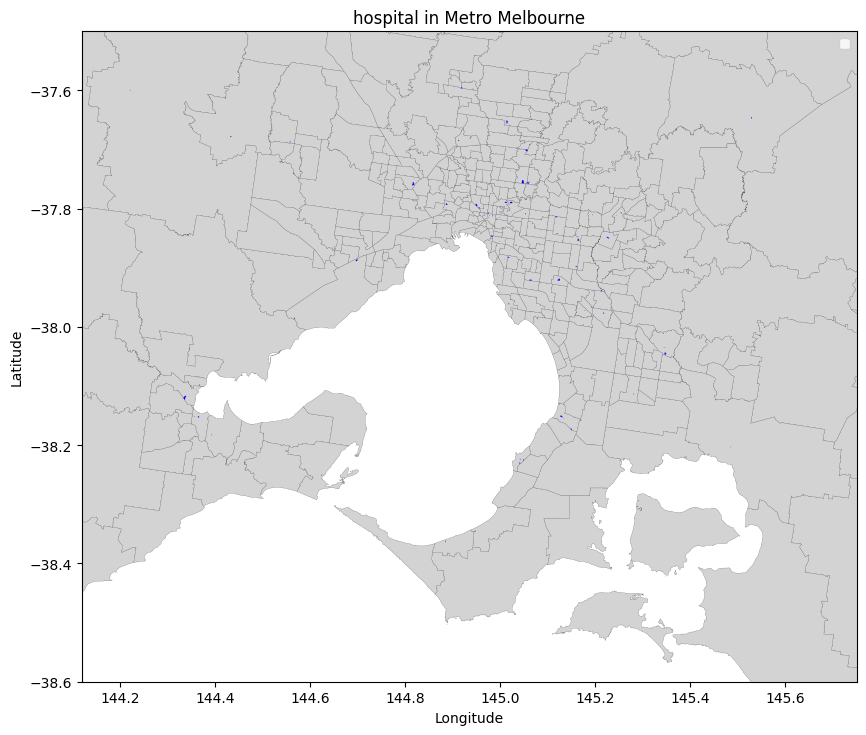

In [6]:
def feat_sf (shapefile, feature_name, feat_type = None, feat_subtypes = None):
    """
    Cleaning shapefiles and dataframes for features we want.

    Args:
        shapefile (gpd.Geodataframe or pd.dataframe): the file with information on neighbourhood features
        feature_name (str): name of the feature
        feat_type (str or list, optional): any specific types of feature we want. Defaults to None.
        feat_subtypes (list, optional): feature subtypes, for example, a chicken is a subtype of a bird . Defaults to None.

    Raises:
        ValueError: feature name is wrong and not mentioned

    Returns:
        gpd.Geodataframe or pd.dataframe: the cleaned shapefile or dataframe
    """
    
    #Removing irrelevant features
    if feature_name in ("shopping", "parks", "hospital") and feat_type is not None and feat_subtypes is not None:
        # We only want features in VIC
        filtered_sf = shapefile[shapefile['STATE'] == "VIC"]
        filtered_sf = filtered_sf[filtered_sf['FTYPE'] == feat_type]
        filtered_sf = filtered_sf[filtered_sf['FEATSUBTYP'].isin(feat_subtypes)]
        
    elif feature_name == "train_station":
        filtered_sf = shapefile[shapefile['STATUS'] == "Active"]
        # Renaming columns for ease of use for future functions
        filtered_sf = filtered_sf.rename(columns={'STATION': 'NAME'})
    
    elif feature_name in ("primary_school", "secondary_school") and feat_type is not None:
        filtered_sf = shapefile[shapefile['School_Type'].isin(feat_type)]
        # Renaming columns for ease of use for future functions
        filtered_sf = filtered_sf.rename(columns={'School_Name': 'NAME'})
        filtered_sf = filtered_sf.rename(columns={'Y': 'latitude'})
        filtered_sf = filtered_sf.rename(columns={'X': 'longitude'})
        filtered_sf = filtered_sf.dropna(subset=['latitude', 'longitude']).copy()
        
        # As the df for school data is just a dataframe, we do not need to convert polygons into coordinates
        return filtered_sf.reset_index(drop=True)
    else:
        # Handle cases where feature_name does not match any known types
        raise ValueError("Invalid feature_name provided.")
        
    # Setting shapefile format
    filtered_sf['geometry'] = filtered_sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    
    # Creating an array of centroids of polygons in the feature shapefiles
    filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))
    filtered_sf['latitude'] = filtered_sf['centroid'].apply(lambda coord: coord[0])
    filtered_sf['longitude'] = filtered_sf['centroid'].apply(lambda coord: coord[1])
    filtered_sf = filtered_sf.dropna(subset=['latitude', 'longitude']).copy()

    return filtered_sf.reset_index(drop=True)  

# Directories
data_dir = '../data/'
landing_dir = data_dir + 'landing/'
curated_dir = data_dir + 'curated/'

foi_sf = gpd.read_file(f"{landing_dir}FOI/GEOMARK_POLYGON.shp")

shopping_type = "commercial facility"
shopping_feature = "shopping"
shopping_labels = ["shopping precinct", "shopping centre"]

shopping_sf = feat_sf(foi_sf, shopping_feature, shopping_type, shopping_labels)

parks_type = "reserve"
parks_feature = "parks"
parks_labels = ["park", "conservation park", "gardens", "national park", "city square"]

parks_sf = feat_sf(foi_sf, parks_feature, parks_type, parks_labels)

hospital_type = "hospital"
hospital_feature = "hospital"
hospital_labels = ["hospital complex"]

hospital_sf = feat_sf(foi_sf, hospital_feature, hospital_type, hospital_labels)

def plot(gdf, feat_sf, feature_name):
    victoria_gdf = gdf[gdf['STE_CODE21'] == '2']
    victoria_gdf = victoria_gdf.to_crs(epsg=4326)
    
    # Plot both the Victoria boundary and feature locations
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if feature_name in ("shopping", "hospital"):
        ax.set_xlim([144.12, 145.75]) 
        ax.set_ylim([-38.6, -37.5]) 
        map_loc = "Metro Melbourne"
    else:
        map_loc = "Victoria"
    
    # Plot Victoria boundaries
    victoria_gdf.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)

    # Plot features on top
    feat_sf.plot(ax=ax, color='blue', markersize=5,  label=feature_name)

    plt.title(f'{feature_name} in {map_loc}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()
            
    return

sa2_path = '../data/sa2_shapefile/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(sa2_path)

plot(gdf, shopping_sf, shopping_feature)
plot(gdf, parks_sf, parks_feature)
plot(gdf, hospital_sf, hospital_feature)



Visulisation of numbers of train stations 

Plot saved to: /home/Daniel Bi/project two/plots/train_stations_zoomed.png


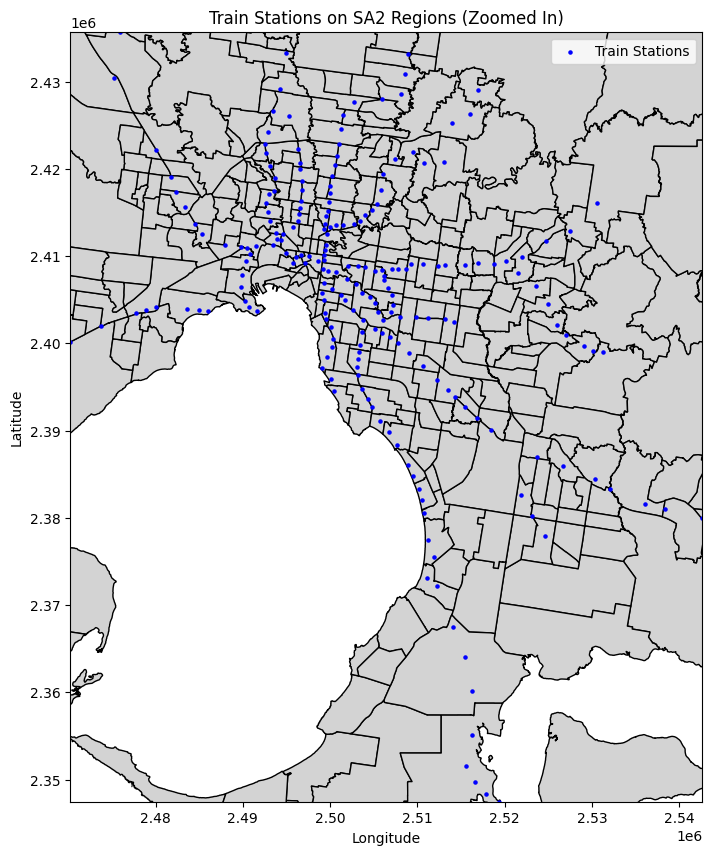

In [2]:
import os
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt

# File paths
sa2_zip_file = '/home/Daniel Bi/project two/data/landing/SA2_2021_AUST_SHP_GDA2020.zip'
extract_dir = '/home/Daniel Bi/project two/data/landing/SA2_extracted'
train_station_shapefile_path = '/home/Daniel Bi/project two/data/landing/PTV_train_station/PTV/PTV_METRO_TRAIN_STATION.shp'

# Create 'plots' directory if it does not exist
plots_dir = '/home/Daniel Bi/project two/plots'
os.makedirs(plots_dir, exist_ok=True)

# Step 1: Extract the SA2 zip file if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(sa2_zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Files extracted to: {extract_dir}")

# Step 2: Find and load the SA2 shapefile
shapefile_name = [file for file in os.listdir(extract_dir) if file.endswith('.shp')]
if not shapefile_name:
    raise FileNotFoundError("No shapefile found in the extracted files.")

# Load the SA2 shapefile
sa2_shapefile_path = os.path.join(extract_dir, shapefile_name[0])
sa2_gdf = gpd.read_file(sa2_shapefile_path)

# Filter to include only Victoria (State code 2)
victoria_gdf = sa2_gdf[sa2_gdf['STE_CODE21'] == '2']

# Step 3: Load the train station shapefile
train_station_gdf = gpd.read_file(train_station_shapefile_path)

# Step 4: Reproject both datasets to a projected coordinate system like EPSG:3111 (Victoria State Grid)
victoria_gdf = victoria_gdf.to_crs(epsg=3111)  # Projected CRS for accurate distance and visualization
train_station_gdf = train_station_gdf.to_crs(epsg=3111)

# Step 5: Define the bounds of the area with train stations to zoom in
bounds = train_station_gdf.total_bounds  # Get the bounds of the train station locations

# Step 6: Plot the SA2 regions and overlay train station points
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Victoria boundaries
victoria_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot train stations as points
train_station_gdf.plot(ax=ax, color='blue', markersize=5, label='Train Stations')

# Set limits to zoom in on the area with train stations
ax.set_xlim([bounds[0], bounds[2]])  # Set x-axis limits (longitude)
ax.set_ylim([bounds[1], bounds[3]])  # Set y-axis limits (latitude)

plt.title('Train Stations on SA2 Regions (Zoomed In)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Save the plot to the 'plots' directory
plot_path = os.path.join(plots_dir, 'train_stations_zoomed.png')
plt.savefig(plot_path, dpi=300)
print(f"Plot saved to: {plot_path}")

# Display the plot
plt.show()


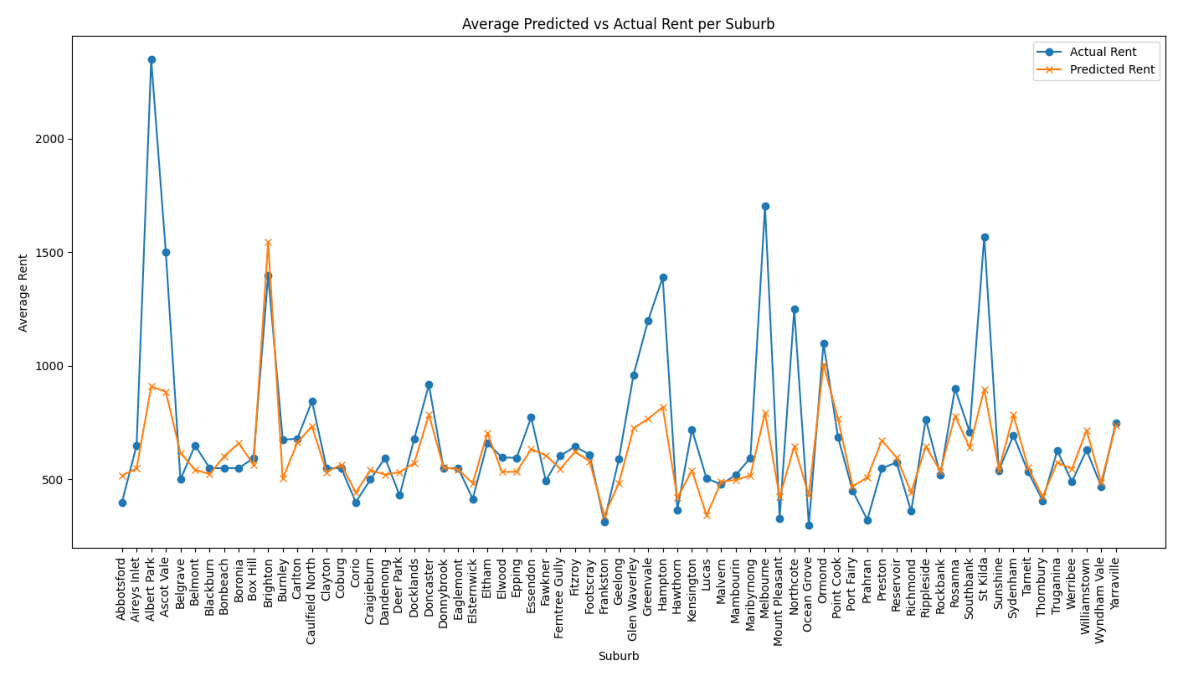

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image from file
img = mpimg.imread('../Modelling_Predict.png')  

# Display the image
plt.figure(figsize=(15, 15)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

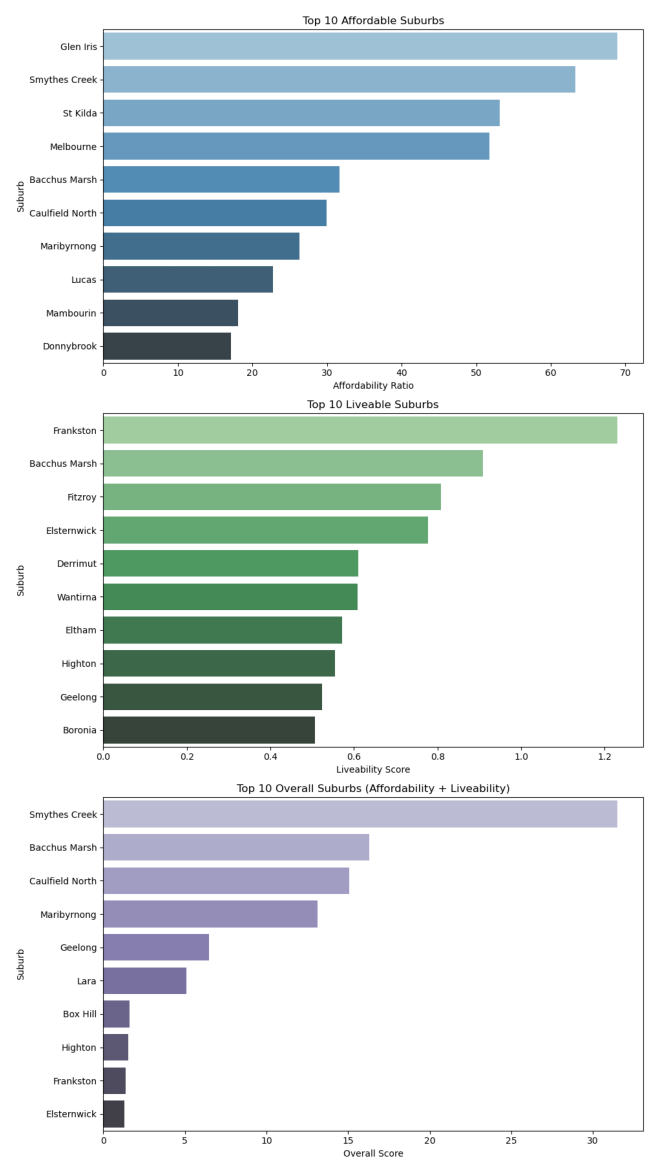

In [11]:
# Load the image from file
img = mpimg.imread('../Suburb_score.png')  

# Display the image
plt.figure(figsize=(15, 15)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

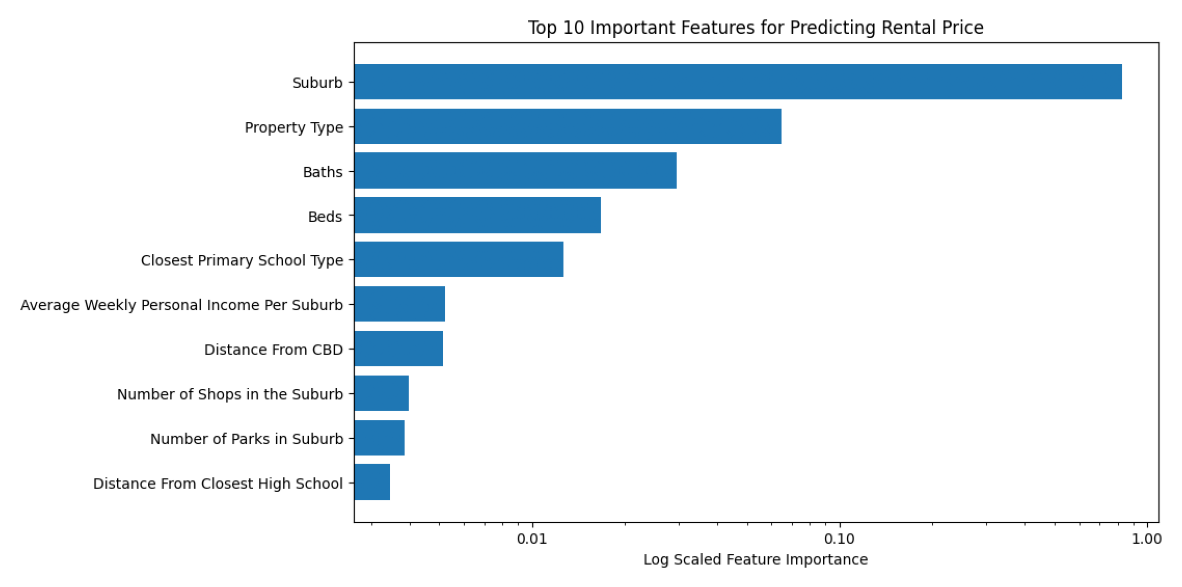

In [12]:
# Load the image from file
img = mpimg.imread('../Top_feats.png')  

# Display the image
plt.figure(figsize=(15, 15)) 
plt.imshow(img)
plt.axis('off')  
plt.show()